In [1]:
import leaderbot as lb
import numpy
import numpy as np
import matplotlib.pyplot as plt
import texplot
import time
import scipy
import pickle
import pandas as pd
import statsmodels.api as sm
from copy import deepcopy
import texplot
from adjustText import adjust_text

In [2]:
# Load form file instead
filename = '../benchmark/models_train_full.pkl'
#filename = '../benchmark/models_train_split.pkl'
with open(filename, 'rb') as f:
    results = pickle.load(f)

lb_models = results['models']
names = np.array(results['data']['models'])

lb_model = lb_models[18-1]
agents = lb_model.agents

In [3]:
matches = {
    "Qwen1.5-110B": "qwen1.5-110b-chat",
    "Qwen1.5 72B": "qwen1.5-72b-chat",
    "Qwen-14B": "qwen-14b-chat",
    "Qwen-VL-Max": "qwen-max-0428",
    "Reka Core": "reka-core-20240501",
    "Reka Flash": "reka-flash-20240722",
    "Gemma 1.1 7B Instruct": "gemma-1.1-7b-it",
    "Gemma 2 9B": "gemma-2-9b-it",
    "Gemma 2 27B": "gemma-2-27b-it",
    "GLM-4 (0116)": "glm-4-0116",
    "PaLM 2": "palm-2",
    "OLMo-7B": "olmo-7b-instruct",
    "Mistral 7B": "mistral-7b-instruct",  # mistral-7b-instruct-v0.2
    "Mistral Large": "mistral-large-2402",
    "Mistral Medium": "mistral-medium",
    "Mixtral 8x7B": "mixtral-8x7b-instruct-v0.1",
    "Nemotron-4 340B": "nemotron-4-340b-instruct",
    "DeepSeek-Coder-V2 236B": "deepseek-coder-v2",
    "DeepSeek LLM 67B": "deepseek-llm-67b-chat",
    # "DeepSeek-V2.5": "deepseek-v2-api-0628",
    "GPT-4o": "gpt-4o-2024-05-13",
    "GPT-4o mini": "gpt-4o-mini-2024-07-18",
    "GPT-3.5 Turbo": "gpt-3.5-turbo-0125",
    "GPT-4 Turbo": "gpt-4-turbo-2024-04-09",
    "GPT-4": "gpt-4-0613",
    "Claude": "claude-1",
    "Claude 2": "claude-2.1", # claude-2.0
    "Claude Instant": "claude-instant-1",
    "Claude 3 Haiku": "claude-3-haiku-20240307",
    "Claude 3 Sonnet": "claude-3-sonnet-20240229",
    "Claude 3 Opus": "claude-3-opus-20240229",
    "Llama 2-13B": "llama-2-13b-chat",
    "Llama 2-70B": "llama-2-70b-chat",
    "Llama 3-70B": "llama-3-70b-instruct",
    "Llama 3-8B": "llama-3-8b-instruct",
    "Llama 3.1-405B": "llama-3.1-405b-instruct",
    "Llama 3.1-70B": "llama-3.1-70b-instruct",
    "Llama 3.1-8B": "llama-3.1-8b-instruct",
    "Yi-34B": "yi-1.5-34b-chat",
    "Yi-Large": "yi-large",
    "phi-3-medium 14B": "phi-3-medium-4k-instruct",
    "phi-3-small 7.4B": "phi-3-small-8k-instruct",
    "Arctic": "snowflake-arctic-instruct",
    "Command R+": "command-r-plus",
    "DBRX": "dbrx-instruct-preview",
    "Gemini 1.5 Pro": "gemini-1.5-pro-api-0514",
}

new_matches = {
    "Gemma 7B": "gemma-7b-it",
    "Mistral Large 2": "mistral-large-2407",
    "MPT-30B (base)": "mpt-30b-chat",
    "Qwen-7B": "qwen1.5-7b-chat",
    "Qwen2-72B": "qwen2-72b-instruct",
    "Falcon-180B": "falcon-180b-chat",
}

matches.update(new_matches)

print(len(matches))

51


In [4]:
df = pd.read_csv("large_scale_ai_models.csv")
df = df[['System', 'Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']]

In [5]:
filtered_df = df[df['System'].isin(matches)]

In [6]:
assert len(filtered_df) == len(matches)

In [7]:
numeric_cols = ['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']

score_mapping = dict(zip(lb_model.agents, lb_model.scores().tolist()))
rev_matches = {v:k for k,v in matches.items()}
score_mapping = {rev_matches[k]: v for k, v in score_mapping.items() if k in rev_matches}
sorted_df = df.copy()

# sorted_df[numeric_cols] = sorted_df[numeric_cols].apply(np.log)
sorted_df[numeric_cols] = sorted_df[numeric_cols] #.apply(np.log)

sorted_df['Score'] = sorted_df['System'].map(score_mapping)
sorted_df = sorted_df.sort_values(by='Score', ascending=True)

# OLS: Combined Relation Between Parameters, FLOPs, and Datasize

In [8]:
import statsmodels.api as sm

# Define independent variables and the dependent variable
X = sorted_df[['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']].apply(np.log)
#X = sorted_df[['Training dataset size (datapoints)']]
y = sorted_df['Score']

# Add a constant column for the intercept
X = sm.add_constant(X)

# Automatically drop rows with NaNs for each variable used
model = sm.OLS(y, X, missing='drop').fit()

# Print the summary of the regression
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     6.891
Date:                Mon, 25 Nov 2024   Prob (F-statistic):            0.00192
Time:                        12:23:08   Log-Likelihood:                 43.208
No. Observations:                  26   AIC:                            -78.42
Df Residuals:                      22   BIC:                            -73.38
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [9]:
import pandas as pd

# Extract key statistics from your fitted OLS model
coefficients = model.params
std_errors = model.bse
t_values = model.tvalues
p_values = model.pvalues
conf_intervals = model.conf_int()

# Create a DataFrame for the table
ols_table = pd.DataFrame({
    'Coefficient': coefficients,
    'Std Error': std_errors,
    't-value': t_values,
    'p-value': p_values,
    # 'Conf Lower': conf_intervals[0],
    # 'Conf Upper': conf_intervals[1]
})

# Add model statistics
model_stats = {
    'R-squared': model.rsquared,
    'Adj R-squared': model.rsquared_adj,
    # 'AIC': model.aic,
    # 'BIC': model.bic
}

# Print table and statistics
print("OLS Coefficients Table:")
print(ols_table)
print("\nModel Statistics:")
print(pd.Series(model_stats))


OLS Coefficients Table:
                                    Coefficient  Std Error   t-value   p-value
const                                 -1.908965   0.423861 -4.503751  0.000176
Parameters                             0.004877   0.013831  0.352627  0.727724
Training compute (FLOP)                0.009397   0.014916  0.630015  0.535174
Training dataset size (datapoints)     0.043973   0.019886  2.211268  0.037713

Model Statistics:
R-squared        0.484452
Adj R-squared    0.414150
dtype: float64


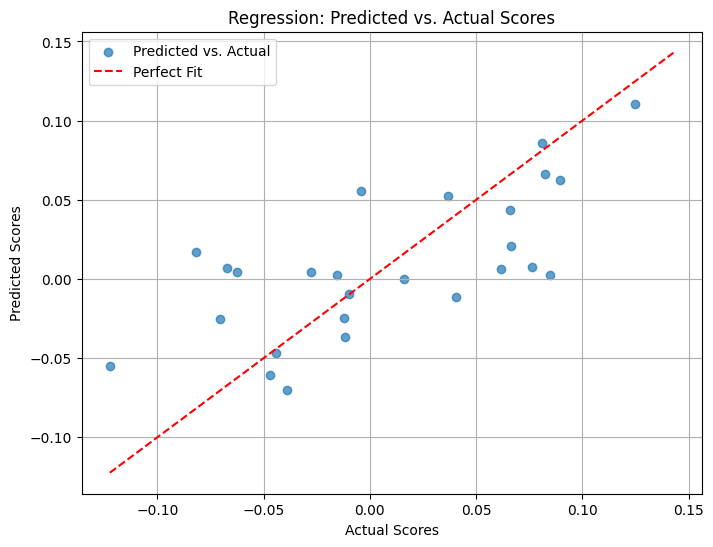

In [10]:
import matplotlib.pyplot as plt

# Predicted scores
predicted_scores = model.predict(X)

# Scatter plot of actual vs. predicted scores
plt.figure(figsize=(8, 6))
plt.scatter(y, predicted_scores, alpha=0.7, label='Predicted vs. Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Regression: Predicted vs. Actual Scores')
plt.legend()
plt.grid()
plt.show()


# OLS: Isolated Individual Relation Between Parameters, FLOPs, and Datasize

In [11]:
# Log-transform the independent variables
X = deepcopy(sorted_df[['Parameters', 'Training compute (FLOP)', 'Training dataset size (datapoints)']]).apply(np.log)
y = deepcopy(sorted_df['Score'])

# Table to collect results
results = []
models = []
correlations = []

# Perform OLS for each input independently
for column in X.columns:

    # Drop NaNs for the specific column and dependent variable
    X_y_individual = deepcopy(pd.concat([X[column], y], axis=1)).dropna()
    X_clean = deepcopy(X_y_individual[[column]])
    y_clean = deepcopy(X_y_individual[y.name])

    pearson = X_clean[column].corr(y_clean, method='pearson')

    # Add intercept
    X_clean = sm.add_constant(X_clean) 

    # Fit the model
    model = sm.OLS(y_clean, X_clean).fit()
    models.append(model)
    
    # Collect results
    results.append({
        "Variable": column,
        "Coeff x100": model.params[column] * 100,
        "Error x100": model.bse[column] * 100,
        "p-Value x100": model.pvalues[column] * 100,
        "R-Squared": model.rsquared,
        "Pearson": pearson,
    })

pd.set_option('display.expand_frame_repr', False)  # Prevent column wrapping
pd.set_option('display.max_columns', None)        # Display all columns
pd.set_option('display.width', 1000)              # Increase display width to fit more columns

# Create results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                             Variable  Coeff x100  Error x100  p-Value x100  R-Squared   Pearson
0                          Parameters    1.621944    0.761502      4.028430   0.114744  0.338739
1             Training compute (FLOP)    2.402952    0.505351      0.004045   0.414028  0.643450
2  Training dataset size (datapoints)    5.526545    1.289084      0.022035   0.414150  0.643545


In [12]:
# Count the number of non-NaN entries for each column in X and y
counts = {
    column: pd.concat([X[column], y], axis=1).dropna().shape[0]
    for column in X.columns
}

print(counts)

{'Parameters': 37, 'Training compute (FLOP)': 34, 'Training dataset size (datapoints)': 28}


Plot saved to "/home/sia/work/github/arenaranking/notebooks/epoch_ai.pdf".


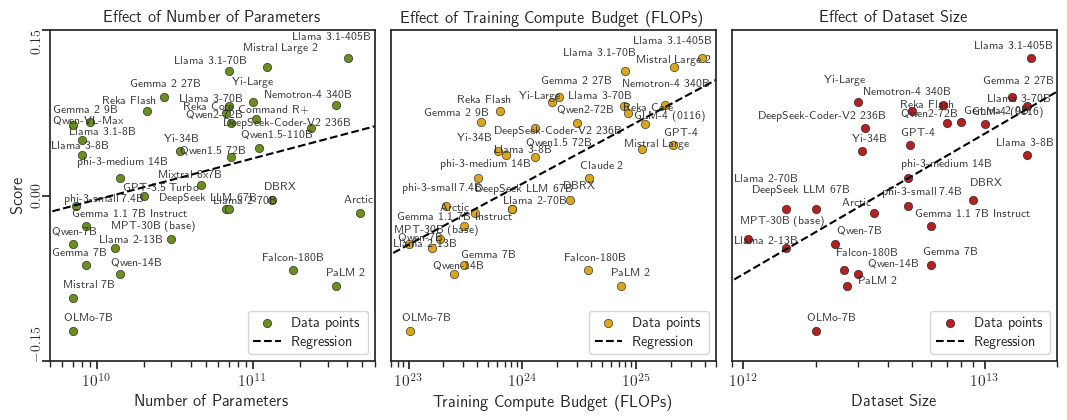

In [16]:
use_latex = True
save = True

with texplot.theme(use_latex=use_latex, font_scale=1, rc={'font.family': 'sans-serif'}):

    # Plot scatter plots and regression lines
    # fig, axes = plt.subplots(ncols=3, figsize=(15, 4.5), sharey=True)
    fig, axes = plt.subplots(ncols=3, figsize=(13, 4.3), sharey=True)
    
    titles = ['Effect of Number of Parameters', 'Effect of Training Compute Budget (FLOPs)', 'Effect of Dataset Size']
    xlabels = ['Number of Parameters', 'Training Compute Budget (FLOPs)', 'Dataset Size']

    colors = ['olivedrab', 'darkgoldenrod', 'maroon']
    colors = ['olivedrab', 'goldenrod', 'firebrick']

    axes[0].set_xlim([5e9, 6e11])
    axes[1].set_xlim([7e22, 5e25])
    axes[2].set_xlim([9e11, 2e13])
    
    for ax, column, model, title, color, xlabel in zip(axes, X.columns, models, titles, colors, xlabels):
        # Drop NaNs for plotting
        X_y_individual = deepcopy(pd.concat([X[column], y], axis=1)).dropna()
        X_clean = deepcopy(X_y_individual[[column]])
        y_clean = deepcopy(X_y_individual[y.name])
    
        # Exponentiate the data to revert log transformation for plotting
        x_actual = np.exp(X_clean[column])  # Original values
        y_actual = y_clean
    
        # Scatter plot with labels for systems
        ax.scatter(x_actual, y_actual, alpha=1, label="Data points", color=color, edgecolors='black', linewidths=0.35)

        # for i, (x_val, y_val) in enumerate(zip(x_actual, y_actual)):
        #     system_label = sorted_df.loc[X_y_individual.index[i], 'System']  # Use correct index lookup
            
        #     # Adjust x_val for edge cases
        #     tol = 0.12
        #     lim = np.log(ax.get_xlim())
        #     if np.log(x_val) < lim[0] + tol * (lim[1] - lim[0]):
        #         ha = 'left'
        #     elif np.log(x_val) > lim[1] - tol * (lim[1] - lim[0]):
        #         ha = 'right'
        #     else:
        #         ha = 'center'
        
        #     # Plot the text
        #     ax.text(x_val, y_val + (0.02 * (y_clean.max() - y_clean.min())),
        #             system_label,
        #             fontsize=8, alpha=0.9, ha=ha)

        # texts = []
        labels = []
        for i, (x_val, y_val) in enumerate(zip(x_actual, y_actual)):
            system_label = sorted_df.loc[X_y_individual.index[i], 'System']
            labels.append(system_label)
            # texts.append(ax.text(np.log(x_val), y_val, system_label, fontsize=8, alpha=0.9, ha='center'))
            
        # adj_texts, _ = 
        # adjust_text(texts, arrowprops=dict(arrowstyle='->', color=(0.2, 0.2, 0.2), lw=0.7), ensure_inside_axes=False)

        # for text_ in texts:
        #     x_, y_ = text_.get_position()
        #     print(x_)
        #     text_.set_position((np.exp(x_), y_))

        # for text in texts:
        #     text.remove()

        # Regression line
        x_vals = np.linspace(X_clean[column].min() - 1.5, X_clean[column].max() + 1.5, 100)
        x_vals_with_intercept = sm.add_constant(pd.DataFrame({column: x_vals}))
        y_vals = model.predict(x_vals_with_intercept)
        x_vals_original = np.exp(x_vals)  # Revert log transformation for x-axis
        ax.plot(x_vals_original, y_vals, '--', color='black', label="Regression")
    
        # Customize plot
        ax.set_xlabel(xlabel)
        ax.legend(fontsize='small', loc='lower right')
        ax.set_title(title)
    
        # Set log scale for x-axis
        ax.set_xscale('log')

        ax.set_ylim([-0.15, 0.15])



        # ==========
        # Create a temporary axes to plot adjust_text, which plots texts with adjusted non-overlapping coordinates
        # but in (log(x), y), since the adjust_text package does not work well with set_scale)'log'). So, instead,
        # we trick it to get x coordinates that are the log of the ctual x. Once adjust_text computed the coordinates.
        # we return the adjusted x coordinates back to exp(x), and we remove the temporary axes.

        temp_ax = fig.add_axes(ax.get_position(), frameon=False)  # No border
        temp_ax.set_xlim(np.log(ax.get_xlim()))  # Set log-space limits
        temp_ax.set_ylim(ax.get_ylim())  # Match y-limits
        
        # Hide the temporary axis
        temp_ax.set_axis_off()

        temp_sc = temp_ax.scatter(np.log(x_actual), y_actual, alpha=1, label="Data points", color=color, edgecolors='black', linewidths=0.35)

        texts = []
        # for x_val, y_val, label in zip(x_log, y_actual, labels):
        for x_val, y_val, label in zip(x_vals, y_actual, labels):
            texts.append(temp_ax.text(x_val, y_val, label, fontsize=8))

        texts = []
        for i, (x_val, y_val) in enumerate(zip(x_actual, y_actual)):
            system_label = sorted_df.loc[X_y_individual.index[i], 'System']
            texts.append(temp_ax.text(np.log(x_val), y_val, system_label, fontsize=8, alpha=0.9, ha='center'))

        adjust_text(
            texts, time_lim=10, ensure_inside_axes=True,
            arrowprops=None,
            ax=temp_ax, objects=temp_sc, 
            force_text=0.04,  # Reduce repulsion between texts
            force_points=0.04,  # Reduce repulsion between text and points
            max_move=0.04,  # Limit maximum movement
        )

        # Extract adjusted positions and apply them to the original axis
        for text, x_val, y_val in zip(texts, x_actual, y_actual):
            x_adj, y_adj = text.get_position()
            ax.text(np.exp(x_adj), y_adj, text.get_text(), fontsize=8, alpha=0.9, ha='center')

        temp_ax.remove()

        # ==============
    
    # Only leftmost subplot has y-ticks and y-label
    for ax in axes[1:]:
        ax.tick_params(left=False, labelleft=False)
    axes[0].set_ylabel("Score")
    axes[0].set_yticks([-0.15, 0, 0.15])
    
    axes[0].tick_params(axis='y', labelrotation=90)

    for label in axes[0].get_yticklabels():
        y_pos = label.get_position()[1]
        if y_pos == axes[0].get_ylim()[0]:
            label.set_verticalalignment('bottom')
        elif y_pos == axes[0].get_ylim()[1]:
            label.set_verticalalignment('top')
        else:
            label.set_verticalalignment('center')
        label.set_horizontalalignment('center')
        label.set_fontsize(10)

    plt.subplots_adjust(wspace=0.05) 

    texplot.show_or_save_plot(plt, default_filename='epoch_ai.pdf',
                              transparent_background=True, dpi=200,
                              show_and_save=save, verbose=True)